# Capital Spending Project Feasibility Assessment: Exploratory Analysis

## Step 0: Setting up and importing data

In [53]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import re
import datetime
import matplotlib.font_manager
from thefuzz import fuzz
from thefuzz import process
import fuzzymatcher
from matplotlib import ticker as ticker

In [3]:
"""
Checkbook NYC data
"""
file_names = ['checkbooknyc/Citywide-Agencies/spending_29351_05312023_040004_part_0.csv', 
'checkbooknyc/Citywide-Agencies/spending_29351_05312023_040004_part_1.csv',
'checkbooknyc/Citywide-Agencies/spending_29351_05312023_040004_part_2.csv',
'checkbooknyc/Citywide-Agencies/spending_29351_05312023_040004_part_3.csv']
df0 = pd.read_csv(file_names[0])
df1 = pd.read_csv(file_names[1])
df2 = pd.read_csv(file_names[2])
df3 = pd.read_csv(file_names[3])
frames = [df0, df1, df2, df3]
df = pd.concat(frames)

facdb = pd.read_csv('facilities.csv')

In [4]:
print("There are {} rows".format(df.shape[0]))
print("There are {} columns".format(df.shape[1]))
print("There are {} unique projects: ".format(len(df["Contract ID"].unique())))
print("There are {} city agencies captured in the dataset: ".format(len(df["Agency"].unique())))
print("The columns are as follows: {}".format(df.dtypes))

df.head(5)

There are 1990934 rows
There are 20 columns
There are 926562 unique projects: 
There are 30 city agencies captured in the dataset: 
The columns are as follows: Agency                        object
Associated Prime Vendor      float64
Budget Code                   object
Capital Project               object
Check Amount                 float64
Contract ID                   object
Contract Purpose              object
Department                    object
Document ID                   object
Emerging Business             object
Expense Category              object
Fiscal year                    int64
Industry                      object
Issue Date                    object
M/WBE Category                object
Payee Name                    object
Spending Category             object
Sub Contract Reference ID    float64
Sub Vendor                    object
Woman Owned Business          object
dtype: object


,Agency,Associated Prime Vendor,Budget Code,Capital Project,Check Amount,Contract ID,Contract Purpose,Department,Document ID,Emerging Business,Expense Category,Fiscal year,Industry,Issue Date,M/WBE Category,Payee Name,Spending Category,Sub Contract Reference ID,Sub Vendor,Woman Owned Business
0,Transit Authority,NaN,"BUSB (MTA, NYCT: PURCHASE 126 HYBRID BUSES)",998CAP2024 005,99999999.95,CT199820231408687,Bus Purch Track Replace Switch Replace Rail Su...,400-998-169,20230231715-1-DSB-EFT,No,CAPITAL PURCHASED EQUIPMENT,2023,Standardized Services,2022-12-21,Individuals and Others,METROPOLITAN TRANSPORTATION AUTHORITY,Capital Contracts,NaN,No,No
1,Transit Authority,NaN,"SAPS (MTA / NYCT: SUBWAY ACTION PLAN, SIGNAL A)",998CAPSAP 003,99999999.59,CT199820191409664,Subway Action Plan Signal Improvement & Modern...,400-998-169,20190025861-1-015-MD1,No,IOTB CONSTRUCTION,2019,Standardized Services,2018-10-30,Individuals and Others,METROPOLITAN TRANSPORTATION AUTHORITY,Capital Contracts,NaN,No,No
2,Department of Education,NaN,E706 (IMPLEMENTATION OF THE SEVENTH FIVE-YEAR),040SCA22 030,99999999.00,PON1040SCA20-24MC,NaN,IMPLEMENTATION OF THE SEVENTH FIVE-YEAR,20220448629-1-DSB-EFT,No,ADMINISTRATIVE EXPENSES,2022,NaN,2022-05-27,Individuals and Others,NYC SCHOOL CONSTRUCTION AUTHORITY,Capital Contracts,NaN,No,No
3,Department of Education,NaN,E706 (IMPLEMENTATION OF THE SEVENTH FIVE-YEAR),040SCA21 030,99999999.00,PON1040SCA20-24MC,NaN,IMPLEMENTATION OF THE SEVENTH FIVE-YEAR,20220448626-1-DSB-EFT,No,CONSTRUCTION-BUILDINGS,2022,NaN,2022-05-27,Individuals and Others,NYC SCHOOL CONSTRUCTION AUTHORITY,Capital Contracts,NaN,No,No
4,Department of Education,NaN,E706 (IMPLEMENTATION OF THE SEVENTH FIVE-YEAR),040SCA21 030,99999999.00,PON1040SCA20-24MC,NaN,IMPLEMENTATION OF THE SEVENTH FIVE-YEAR,20220354644-1-DSB-EFT,No,CONSTRUCTION-BUILDINGS,2022,NaN,2022-03-25,Individuals and Others,NYC SCHOOL CONSTRUCTION AUTHORITY,Capital Contracts,NaN,No,No


In [5]:
print("Number of rows in FacDB: {} ".format(facdb.shape[0]))
print("Number of cols in FacDB: {} ".format(facdb.shape[1]))
print("List of columns in FacDB: {} ".format(facdb.columns))
print("Number of facility types: {} ".format(len(facdb["factype"].unique())))
print("Number of facility subgroups: {}".format(len(facdb["facsubgrp"].unique())))
print("Number of facility groups: {}".format(len(facdb["facgroup"].unique())))

facdb.head(5)

Number of rows in FacDB: 33429 
Number of cols in FacDB: 38 
List of columns in FacDB: Index(['facname', 'addressnum', 'streetname', 'address', 'city', 'zipcode',
       'boro', 'borocode', 'bin', 'bbl', 'cd', 'nta2010', 'nta2020', 'council',
       'schooldist', 'policeprct', 'ct2010', 'ct2020', 'factype', 'facsubgrp',
       'facgroup', 'facdomain', 'servarea', 'opname', 'opabbrev', 'optype',
       'overagency', 'overabbrev', 'overlevel', 'capacity', 'captype',
       'latitude', 'longitude', 'xcoord', 'ycoord', 'datasource', 'uid',
       'geom'],
      dtype='object') 
Number of facility types: 603 
Number of facility subgroups: 71
Number of facility groups: 25


,facname,addressnum,streetname,address,city,zipcode,boro,borocode,bin,bbl,...,overlevel,capacity,captype,latitude,longitude,xcoord,ycoord,datasource,uid,geom
0,HEALTHY CHOICES,153A,JOHNSON AVENUE,153A JOHNSON AVENUE,BROOKLYN,11206.0,BROOKLYN,3.0,3400456.0,3.030610e+09,...,City,NaN,NaN,40.706891,-73.944040,9.997651e+05,196821.066036,nysed_activeinstitutions,0001260a0a6ef16ae013d969ed1fb0d4,0101000020E6100000C0772D256B7C52C08994806B7B5A...
1,HANAC INC,4-05,ASTORIA BOULEVARD,4-05 ASTORIA BOULEVARD,ASTORIA,11102.0,QUEENS,4.0,4430787.0,4.004900e+09,...,City,NaN,NaN,40.773552,-73.934847,1.002296e+06,221109.390826,moeo_socialservicesitelocations,0008eddb5491c32a466da1e3f6616133,0101000020E6100000E11D258AD47B52C0FD4019C10363...
2,ACADEMY OF ST. DOROTHY SCHOOL,1305,HYLAN BOULEVARD,1305 HYLAN BOULEVARD,STATEN ISLAND,10305.0,STATEN ISLAND,5.0,5107505.0,5.032150e+09,...,City,NaN,NaN,40.597552,-74.086062,9.603500e+05,156992.605774,dohmh_daycare,0010005ff23d67162ed90ab272d009d9,0101000020E6100000180F5E0A828552C0920C08997C4C...
3,UNIVERSITY OF NOTRE DAME ALUM- NI CLUB OF STAT...,64,BLOOMINGDALE ROAD,64 BLOOMINGDALE ROAD,STATEN ISLAND,10309.0,STATEN ISLAND,5.0,5086937.0,5.074950e+09,...,City,NaN,NaN,40.525718,-74.215998,9.242015e+05,130883.972684,moeo_socialservicesitelocations,0016b3c3e5e8aeadccacf07a9fbb7c76,0101000020E6100000EC463EE8D28D52C0479A97BC4A43...
4,"FUND FOR THE CITY OF NEW YORK, INC.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,City,NaN,NaN,NaN,NaN,NaN,NaN,moeo_socialservicesitelocations,001a154dfc404f91b93b1cc825ea3d88,NaN


## Step 1: Data Cleaning

In [34]:
df['Issue Date'] = pd.to_datetime(df['Issue Date'])
df['Fiscal year'] = pd.to_datetime(df['Fiscal year'], format='%Y')
df['Agency'] = df['Agency'].str.upper()
df['Budget Code'] = df['Budget Code'].str.upper()
df['Contract Purpose'] = df['Contract Purpose'].str.upper()
df['Spending Category'] = df['Spending Category'].str.upper()

In [33]:
# clean facdb maybe

,facname,addressnum,streetname,address,city,zipcode,boro,borocode,bin,bbl,...,overlevel,capacity,captype,latitude,longitude,xcoord,ycoord,datasource,uid,geom
0,HEALTHY CHOICES,153A,JOHNSON AVENUE,153A JOHNSON AVENUE,BROOKLYN,11206.0,BROOKLYN,3.0,3400456.0,3.030610e+09,...,City,NaN,NaN,40.706891,-73.944040,9.997651e+05,196821.066036,nysed_activeinstitutions,0001260a0a6ef16ae013d969ed1fb0d4,0101000020E6100000C0772D256B7C52C08994806B7B5A...
1,HANAC INC,4-05,ASTORIA BOULEVARD,4-05 ASTORIA BOULEVARD,ASTORIA,11102.0,QUEENS,4.0,4430787.0,4.004900e+09,...,City,NaN,NaN,40.773552,-73.934847,1.002296e+06,221109.390826,moeo_socialservicesitelocations,0008eddb5491c32a466da1e3f6616133,0101000020E6100000E11D258AD47B52C0FD4019C10363...
2,ACADEMY OF ST. DOROTHY SCHOOL,1305,HYLAN BOULEVARD,1305 HYLAN BOULEVARD,STATEN ISLAND,10305.0,STATEN ISLAND,5.0,5107505.0,5.032150e+09,...,City,NaN,NaN,40.597552,-74.086062,9.603500e+05,156992.605774,dohmh_daycare,0010005ff23d67162ed90ab272d009d9,0101000020E6100000180F5E0A828552C0920C08997C4C...
3,UNIVERSITY OF NOTRE DAME ALUM- NI CLUB OF STAT...,64,BLOOMINGDALE ROAD,64 BLOOMINGDALE ROAD,STATEN ISLAND,10309.0,STATEN ISLAND,5.0,5086937.0,5.074950e+09,...,City,NaN,NaN,40.525718,-74.215998,9.242015e+05,130883.972684,moeo_socialservicesitelocations,0016b3c3e5e8aeadccacf07a9fbb7c76,0101000020E6100000EC463EE8D28D52C0479A97BC4A43...
4,"FUND FOR THE CITY OF NEW YORK, INC.",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,City,NaN,NaN,NaN,NaN,NaN,NaN,moeo_socialservicesitelocations,001a154dfc404f91b93b1cc825ea3d88,NaN


## Fuzzy String Matching

In [35]:
bpcl = facdb[facdb['facname']=='BATTERY PARK CITY LIBRARY']
bpcl_df = pd.concat([df.iloc[[129994]], df.iloc[[243370]]])

df_joined = fuzzymatcher.fuzzy_left_join(bpcl_df, bpcl, left_on = "Budget Code", right_on="facname")
num_records = len(df_joined)
correct_binary = (df_joined["facname"] == df_joined["Budget Code"])
perc_correct = correct_binary.sum()/num_records

In [36]:
# brute force regex
regex_pattern = '(\d+\s+AVE|\d+\s+STREET|BLOCK|LOT|\d+\s+ST|\d+\s+AVENUE)+'
pattern_results = df['Budget Code'].apply(lambda x: re.findall(regex_pattern, str(x))[0] if re.findall(regex_pattern, str(x)) != [] else None)

df['Street Info'] = pattern_results

In [37]:
num_mentions = df[df['Street Info'].notnull()].shape[0]
print("Proportion of all rows from Checkbook NYC with street mentions: {}".format(num_mentions/df.shape[0]))

Proportion of all rows from Checkbook NYC with street mentions: 0.004103601626171435


In [38]:
df[df['Street Info'].notnull()].head(5)

,Agency,Associated Prime Vendor,Budget Code,Capital Project,Check Amount,Contract ID,Contract Purpose,Department,Document ID,Emerging Business,...,Fiscal year,Industry,Issue Date,M/WBE Category,Payee Name,Spending Category,Sub Contract Reference ID,Sub Vendor,Woman Owned Business,Street Info
377,DEPARTMENT OF PARKS AND RECREATION,NaN,"BQ64 (DPR: ACQUISITION OF BLOCK 2277, LOT 01,)",846P-2GPWB01500,47950000.0,POC01520152022817,PURCHASE OPTION BLOCK 2277 LOT 1,DEVELOPMENT OF WATERFRONT PARK AND ADJAC,20160120460-1-DSB-AD,No,...,2016-01-01,Standardized Services,2015-12-29,Non-M/WBE,NORTH 12TH STREET PROPERTIES LLC,CAPITAL CONTRACTS,NaN,No,No,BLOCK
378,DEPARTMENT OF PARKS AND RECREATION,NaN,"BQ64 (DPR: ACQUISITION OF BLOCK 2277, LOT 01,)",846P-2GPWB01500,47950000.0,POC01520152022817,PURCHASE OPTION BLOCK 2277 LOT 1,DEVELOPMENT OF WATERFRONT PARK AND ADJAC,20160001824-1-DSB-AD,No,...,2016-01-01,Standardized Services,2015-07-06,Non-M/WBE,NORTH 12TH STREET PROPERTIES LLC,CAPITAL CONTRACTS,NaN,No,No,BLOCK
493,HOUSING PRESERVATION AND DEVELOPMENT,NaN,"261E (CAMBA.261 EAST 202 ST & 271 EAST 203 ST,)",806SHLP21 005,30551596.0,POC80620212006332,CAROL HAMLER 212 863-6624 HAMLERC@HPD.NYC.GOV,400-806-323,20210247201-1-DSB-EFT,No,...,2021-01-01,Standardized Services,2021-01-28,Non-M/WBE,CHV BEDFORD PARK LP,CAPITAL CONTRACTS,NaN,No,No,202 ST
567,DEPARTMENT OF EDUCATION,NaN,"Q816 (PS256Q 445 BEACH 135TH ST (BLOCK 16258,)",040SANDYCOST020,25474165.0,PON1040SCA15-19MC,NaN,400-040-693,20210281079-1-DSB-EFT,No,...,2021-01-01,NaN,2021-02-25,Individuals and Others,NYC SCHOOL CONSTRUCTION AUTHORITY,CAPITAL CONTRACTS,NaN,No,No,BLOCK
623,POLICE DEPARTMENT,NaN,"MOU1 (NYPD: ACQUISITION OF 770 11TH AVE, BLOCK)",856PO79MOU 003,22500000.0,POC01520142007216,BLOCK 1082 LOT 1004 - PURCHASE OPTION-BUILDING,400-056-224,20140020416-1-015-MD1,No,...,2014-01-01,Standardized Services,2013-11-26,Non-M/WBE,CLINTON PARK HOLDINGS LLC,CAPITAL CONTRACTS,NaN,No,No,BLOCK


# Department of Education: A very bad example of record linkage

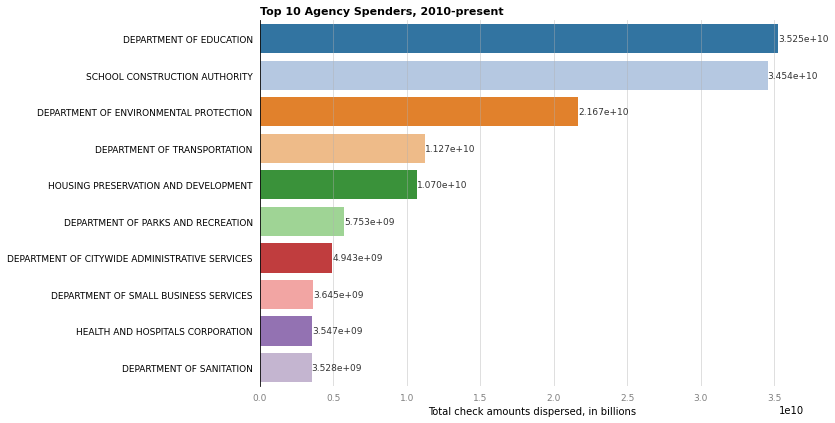

In [54]:
# --- SPENDING BY AGENCY
spending_by_agency = df.groupby('Agency')['Check Amount'].sum().sort_values(ascending=True)
spending_df = spending_by_agency.tail(10).to_frame().reset_index()
spending_df.sort_values('Check Amount', ascending=False, inplace=True)

# --- plot --- 
fig, axs = plt.subplots(figsize=(12,6), nrows = 1)
ax = axs
sns.barplot(data=spending_df, y='Agency', x='Check Amount', ax=ax, palette = 'tab20')

"""
for p in ax.patches:
    ax.annotate( str(p.get_width()), (p.get_width() + 0.75 , p.get_y()+0.075 ), fontsize=9, fontweight='light', alpha = 0.8, color='black', va='bottom')
"""

for p in ax.patches:
    width = p.get_width()
    label = f"{width:.3e}"
    ax.annotate(label, (width, p.get_y() + p.get_height() / 2), fontsize=9, fontweight='light', alpha=0.8, color='black', ha='left', va='center')

# tick marks and 0-line
sns.despine(ax=ax, bottom = True )
ax.tick_params( left=False, bottom=False )
ax.set_title("Top 10 Agency Spenders, 2010-present", fontsize=11, fontweight="bold", loc="left")
ax.grid(axis='x', linestyle='-', alpha=0.5, zorder = 0 )
ax.set_ylabel("")
ax.set_xlabel("Total check amounts dispersed, in billions")
plt.tight_layout( h_pad=1 )

# change x-tick fonts
for tick in ax.get_xticklabels():
    tick.set_fontsize(9)
    tick.set_color( 'grey' )

# change y-tick fonts
for tick in ax.get_yticklabels():
    tick.set_fontsize(9)
    tick.set_color( 'black' )

#plt.barh(spending_by_agency.index, spending_by_agency)
plt.show()

In [ ]:
# identify faciltiies
doe_df = df[df['Agency']=='DEPARTMENT OF EDUCATION']

overagency = ['NYC Department of Education']
facgroup = ['DAY CARE AND PRE-KINDERGARTEN', 'YOUTH SERVICES', 'CAMPS', 'VOCATIONAL AND PROPRIETARY SCHOOLS', 'SCHOOLS (K-12)', 'LIBRARIES', 'HIGHER EDUCATION']
facsubgrp = ['AFTER-SCHOOL PROGRAMS', 'PROPRIETARY SCHOOLS', 'CHARTER K-12 SCHOOLS', 'PUBLIC K-12 SCHOOLS', 'NON-PUBLIC K-12 SCHOOLS', 
'PUBLIC AND PRIVATE SPECIAL EDUCATION SCHOOLS', 'GED AND ALTERNATIVE HIGH SCHOOL EQUIVALENCY', 'PRESCHOOLS FOR STUDENTS WITH DISABILITIES', 
'HEAD START', 'COLLEGES OR UNIVERSITIES', 'DOE UNIVERSAL PRE-KINDERGARTEN']
facdomain = ['EDUCATION, CHILD WELFARE, AND YOUTH']

doe_facdb = facdb[['facname', 'address']][(facdb['overagency'].isin(overagency)) \
     | (facdb['facgroup'].isin(facgroup)) \
     | (facdb['facsubgrp'].isin(facsubgrp)) \
     | (facdb['facdomain'].isin(facdomain))]

There are 15684 rows in the facilities database pertaining to DOE-overseen or education-related programs and facilities.


/var/folders/7p/9414x_x93rvb4p6kc2ny_wl00000gn/T/ipykernel_40452/2583445349.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doe_df['facname'] = None
/var/folders/7p/9414x_x93rvb4p6kc2ny_wl00000gn/T/ipykernel_40452/2583445349.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  doe_df['address'] = None


KeyboardInterrupt: 

In [57]:
# Perform fuzzy matching and left join on 'facname'
matched_results_facname = fuzzymatcher.fuzzy_left_join(doe_df, doe_facdb, left_on='Budget Code', right_on='facname')
matched_results_facname = matched_results_facname[matched_results_facname['best_match_score'] > 0.3]

# Perform fuzzy matching and left join on 'address'
matched_results_address = fuzzymatcher.fuzzy_left_join(doe_df, doe_facdb, left_on='Budget Code', right_on='address')
matched_results_address = matched_results_address[matched_results_address['best_match_score'] > 0.3]


# Combine the matched results from both joins
combined_results = pd.concat([matched_results_facname, matched_results_address])

In [59]:
# summary stats about DOE
print("Number of checks by DOE: {}".format(doe_df.shape[0]))
print("Percent of total $ disbursed by DOE: {}".format(sum(doe_df['Check Amount'])/sum(df['Check Amount'])))
print("Number of matches on DOE checks using fuzzy string matching: {}".format(combined_results.shape[0]))
print("Percent of records matched: {}".format(combined_results.shape[0]/doe_df.shape[0]))

Number of checks by DOE: 1726
Percent of total $ disbursed by DOE: 0.23168862038614596
Number of matches on DOE checks using fuzzy string matching: 36
Percent of records matched: 0.02085747392815759


# SCA as a bad example 


In [60]:
sca_df = df[df['Agency']=='SCHOOL CONSTRUCTION AUTHORITY']

# Perform fuzzy matching and left join on 'facname'
sca_matched_results_facname = fuzzymatcher.fuzzy_left_join(sca_df, doe_facdb, left_on='Budget Code', right_on='facname')
sca_matched_results_facname = sca_matched_results_facname[sca_matched_results_facname['best_match_score'] > 0.3]

# Perform fuzzy matching and left join on 'address'
sca_matched_results_address = fuzzymatcher.fuzzy_left_join(sca_df, doe_facdb, left_on='Budget Code', right_on='address')
sca_matched_results_address = sca_matched_results_address[sca_matched_results_address['best_match_score'] > 0.3]


# Combine the matched results from both joins
sca_combined_results = pd.concat([matched_results_facname, matched_results_address])

KeyboardInterrupt: 

In [73]:
# grouping checks together

print(df.shape[0])
print(df.columns)

projects = df.groupby(['Capital Project', 'Fiscal year']).agg({'Check Amount': 'sum', 
'Agency':'first', 'Budget Code': 'first'
})

agencies = df['Agency'].unique()
agency_dict= {}

for a in agencies:
    agency_dict[a] = projects[projects['Agency']==a]

1990934
Index(['Agency', 'Associated Prime Vendor', 'Budget Code', 'Capital Project',
       'Check Amount', 'Contract ID', 'Contract Purpose', 'Department',
       'Document ID', 'Emerging Business', 'Expense Category', 'Fiscal year',
       'Industry', 'Issue Date', 'M/WBE Category', 'Payee Name',
       'Spending Category', 'Sub Contract Reference ID', 'Sub Vendor',
       'Woman Owned Business', 'Street Info'],
      dtype='object')


In [78]:
all_facdomains = facdb['facdomain'].unique()
print(facdb['facdomain'].unique())
all_facgroups = facdb['facgroup'].unique()
print(facdb['facgroup'].unique())
all_facsubgrps = facdb['facsubgrp'].unique()
print(len(facdb['facsubgrp'].unique()))

['EDUCATION, CHILD WELFARE, AND YOUTH' 'HEALTH AND HUMAN SERVICES'
 'PUBLIC SAFETY, EMERGENCY SERVICES, AND ADMINISTRATION OF JUSTICE'
 'PARKS, GARDENS, AND HISTORICAL SITES'
 'CORE INFRASTRUCTURE AND TRANSPORTATION'
 'LIBRARIES AND CULTURAL PROGRAMS' 'ADMINISTRATION OF GOVERNMENT']
['CHILD SERVICES AND WELFARE' 'YOUTH SERVICES'
 'DAY CARE AND PRE-KINDERGARTEN' 'HUMAN SERVICES' 'CAMPS' 'HEALTH CARE'
 'ADULT SERVICES' 'JUSTICE AND CORRECTIONS' 'HISTORICAL SITES'
 'TRANSPORTATION' 'VOCATIONAL AND PROPRIETARY SCHOOLS' 'PARKS AND PLAZAS'
 'CULTURAL INSTITUTIONS' 'SOLID WASTE' 'SCHOOLS (K-12)' 'LIBRARIES'
 'PUBLIC SAFETY' 'OFFICES, TRAINING, AND TESTING' 'HIGHER EDUCATION'
 'CITY AGENCY PARKING, MAINTENANCE, AND STORAGE' 'WATER AND WASTEWATER'
 'EMERGENCY SERVICES' 'MATERIAL SUPPLIES AND MARKETS' 'OTHER PROPERTY'
 'TELECOMMUNICATIONS']
71


In [83]:
parks_df = agency_dict['DEPARTMENT OF PARKS AND RECREATION']
parks_groups = ['HISTORICAL SITES','PARKS AND PLAZAS',
'CULTURAL INSTITUTIONS', 'CITY AGENCY PARKING, MAINTENANCE, AND STORAGE']
parks_domains = ['PARKS, GARDENS, AND HISTORICAL SITES']
parks_subgroups = ['PARKS','RECREATION AND WATERFRONT SITES', 'OTHER CULTURAL INSTITUTIONS', 
'GARDENS', 'MAINTENANCE AND GARAGES', 'PRESERVES AND CONSERVATION AREAS']
parks_facdb = facdb[(facdb['overagency']=='NYC Department of Parks and Recreation')|facdb['overagency']=='The New York State Office of Parks, Recreation, and Historic Preservation']

parks_facdb = facdb[['facname', 'address']][(facdb['overagency']=='NYC Department of Parks and Recreation') \
     | (facdb['overagency']=='The New York State Office of Parks, Recreation, and Historic Preservation') \
     | (facdb['facgroup'].isin(parks_groups)) \
     | (facdb['facsubgrp'].isin(parks_subgroups)) \
     | (facdb['facdomain'].isin(parks_domains))]

In [85]:
print(parks_df.shape[0])
print(parks_facdb.shape[0])

19634
6416


Check Amount                              Agency  \
Capital Project Fiscal year                                                     
056P-103CCAM100 2018-01-01      353175.00  DEPARTMENT OF PARKS AND RECREATION   
                2019-01-01       25675.50  DEPARTMENT OF PARKS AND RECREATION   
801AHGREEN  001 2017-01-01      895688.56  DEPARTMENT OF PARKS AND RECREATION   
                2018-01-01      331527.16  DEPARTMENT OF PARKS AND RECREATION   
                2019-01-01      448880.95  DEPARTMENT OF PARKS AND RECREATION   

                                                                 Budget Code  
Capital Project Fiscal year                                                   
056P-103CCAM100 2018-01-01   AGUS (ARGUS CCTV SECURITY CAMERA SYSTEM, NYPD:)  
                2019-01-01   AGUS (ARGUS CCTV SECURITY CAMERA SYSTEM, NYPD:)  
801AHGREEN  001 2017-01-01   AHGP (ANDREW HASWELL GREEN PK, PHASE 2B, MN: E)  
                2018-01-01   AHGP (ANDREW HASWELL GREEN PK, PHASE 2B, MN: E)  
                2019-01-01   AHGP (ANDREW HASWELL GREEN PK, PHASE 2B, MN: E)

In [86]:
# Perform fuzzy matching and left join on 'facname'
parks_matched_results_facname = fuzzymatcher.fuzzy_left_join(parks_df, parks_facdb, left_on='Budget Code', right_on='facname')
parks_matched_results_facname = parks_matched_results_facname[parks_matched_results_facname['best_match_score'] > 0.3]

# Perform fuzzy matching and left join on 'address'
parks_matched_results_address = fuzzymatcher.fuzzy_left_join(parks_df, parks_facdb, left_on='Budget Code', right_on='address')
parks_matched_results_address = parks_matched_results_address[parks_matched_results_address['best_match_score'] > 0.3]


# Combine the matched results from both joins
parks_combined_results = pd.concat([parks_matched_results_facname, parks_matched_results_address])

In [89]:
# summary stats about DOE
print("Sum of checks issued by Dep of Parks and Rec: {}".format(sum(parks_df['Check Amount'])))
print("Percent of total $ disbursed by Dep of Parks and Rec: {}".format(sum(parks_df['Check Amount'])/sum(df['Check Amount'])))
print("Number of matches on Dep of Parks and Rec checks using fuzzy string matching: {}".format(parks_combined_results.shape[0]))
print("Percent of money matched: {}".format(sum(parks_combined_results['Check Amount'])/sum(parks_df['Check Amount'])))

Sum of checks issued by Dep of Parks and Rec: 5753173909.239989
Percent of total $ disbursed by Dep of Parks and Rec: 0.037817684718903725
Number of matches on SCA checks using fuzzy string matching: 586
Percent of money matched: 0.03221628162714186


902538


IndexError: positional indexers are out-of-bounds